### An attempt at reconstructing baselines from SOTA on the FakeNewsNet dataset

In [40]:
from pathlib import Path

import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
pd.options.future.infer_string = True

In [41]:
from itertools import product
from collections import defaultdict


# Inspiration from ChatGPT
def get_tuple_combinations(list1, list2):
    combinations = [(item1, item2) for item1, item2 in product(list1, list2) if item1 != item2 and item1 < item2]
    return combinations

In [42]:
# Set path to data folder
DATA_DIR = Path(r"C:\Users\jakob\Desktop\UniStuff\02807_CompTools_Project\data")

In [43]:
dataset = 'BuzzFeed'

In [46]:
# Load social content data - i.e. user and news "interactions" 
newsId = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeedNews.txt', sep='\t', header=None)
userId = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeedUser.txt', sep='\t', header=None)

# Create index mappings
idx2newsId = {i+1: key for i, key in enumerate(newsId[0])}
idx2userId = {i+1: key for i, key in enumerate(userId[0])}

# Add real user and news ids/names to dataframe
NewsUser            = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeedNewsUser.txt', sep='\t', header=None).rename(columns={0: 'newsIndex', 1: 'userIndex', 2: 'n_shares'})
NewsUser['newsId']  = NewsUser['newsIndex'].map(idx2newsId) 
NewsUser['userId']  = NewsUser['userIndex'].map(idx2userId)

# Show resulting dataframe
print(NewsUser.shape)
NewsUser.head()

(22779, 5)


,newsIndex,userIndex,n_shares,newsId,userId
0,45,1,1,BuzzFeed_Real_45,98d2b98ce305174e2f6c10b8f8a1a9d5
1,127,2,1,BuzzFeed_Fake_36,a273d0fd07c18a884ce2aa425813eb06
2,115,3,1,BuzzFeed_Fake_24,ac091e92df9e854a07563ffb397925d4
3,180,3,1,BuzzFeed_Fake_89,ac091e92df9e854a07563ffb397925d4
4,140,4,1,BuzzFeed_Fake_49,d2ded2de054f2ceb43dff7f80fc46774


In [64]:
# Load content of news data
fake_news       = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeed_fake_news_content.csv', engine="pyarrow")
real_news       = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeed_real_news_content.csv', engine="pyarrow")
fake_news['class'] = 0 
real_news['class'] = 1
df              = pd.concat([real_news, fake_news]).reset_index(drop=True)
df['news_id']   = newsId
df.to_csv(DATA_DIR / 'processed/FakeNewsNet/BuzzFeedNewsContent.csv', index=False)

df

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,news_id
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",1,BuzzFeed_Real_1
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",1,BuzzFeed_Real_2
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",1,BuzzFeed_Real_3
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b...",1,BuzzFeed_Real_4
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict...",1,BuzzFeed_Real_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Fake_88-Webpage,Hillary’s TOP Donor Country Just Auctioned Off...,Hillary’s TOP Donor Country Just Auctioned Off...,http://rightwingnews.com/hillary-clinton-2/hil...,http://rightwingnews.com/wp-content/uploads/20...,Terresa Monroe-hamilton,http://rightwingnews.com,{'$date': 1474912025000},NaN,http://1.gravatar.com/avatar/d35b77ff6c3900715...,http://rightwingnews.com/hillary-clinton-2/hil...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",0,BuzzFeed_Fake_87
178,Fake_89-Webpage,Cavuto Just Exposed Lester Holt's Lies During ...,Advertisement - story continues below The f...,http://conservativetribune.com/lester-holt-lie...,http://conservativetribune.com/wp-content/uplo...,"Martin Lioll,John Falkenberg,Ben Marquis,Kimbe...",http://conservativetribune.com,{'$date': 1474934400000},https://www.youtube.com/embed/ThwaDSaoGU8?feat...,http://conservativetribune.com/wp-content/uplo...,http://conservativetribune.com/lester-holt-lie...,"{""description"": ""People are already calling th...",0,BuzzFeed_Fake_88
179,Fake_9-Webpage,"The AP, In 2004, Said Your Boy Obama Was BORN ...",Well THAT’S Weird. If the Birther movement is ...,http://clashdaily.com/2016/09/dear-cnn-ap-2004...,http://clashdaily.com/wp-content/uploads/2016/...,"Rich Witmer,Doug Giles",http://clashdaily.com,{'$date': 1474207108000},NaN,http://clashdaily.wpengine.netdna-cdn.com/wp-c...,http://clashdaily.com/2016/09/dear-cnn-ap-2004...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",0,BuzzFeed_Fake_89
180,Fake_90-Webpage

In [48]:
def clean_dataframe(df, col, exclude):
    """
    Traverse dataframe columns and drop values given by 'exclude'
    """
    if type(col)=='list':
        try:
            for ind, c in enumerate(col):
                indices = df[df[c]==exclude[ind]].index
                df = df.drop(indices)
        except:
            print('Exception occurred, check kwargs')
    else:
        indices = df[df[col]==exclude].index
        df = df.drop(indices)
    return df

df_cleaned = clean_dataframe(df=df, col='text', exclude='')

df_cleaned.head()
print(df_cleaned.shape)

(182, 14)


In [49]:
df['class'].value_counts() / df.shape[0] * 100

class
1    50.0
0    50.0
Name: count, dtype: float64

In [50]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.corpus import stopwords
stopwords.words('english')
def cleanwordcounts(text):
    #returns words counts minus stopwords from nltk and chinese characters
    #expects pandas series or single string
    #CountVectorizer expects iterable over raw text documents, so transform text
    #if simple string
    if type(text)==str:
        text = [text,'']
    
    stpwords = stopwords.words('english')
    #instantiate countvectorizer
    tokens = CountVectorizer(stop_words=stpwords,analyzer='word',token_pattern=r'\w+')
    #transform corpus into vector space
    textvec = pd.DataFrame(tokens.fit_transform(text).toarray())
    #create counts dataframe
    counts = pd.DataFrame(list(zip(tokens.get_feature_names_out(),textvec.sum().values)),columns=['word','counts'])
    #remove any chinese characters
    counts['word'] = counts['word'].str.replace(r'[^\x00-\x7F]+', '')
    #drop rows where chinese characters residedp
    counts.drop(counts[counts['word']==''].index, inplace=True)
    return counts.sort_values(by=['counts'],ascending=False).reset_index(drop=True)

In [15]:
import sklearn
sklearn.__version__

'1.3.0'

In [54]:
# Top words in the dataset w.r.t. real or fake.
from itertools import chain
fake_words, true_words = list(), list()
fake_words.append(list(cleanwordcounts(fake_news.text).word.head(15)))
true_words.append(list(cleanwordcounts(real_news.text).word.head(15)))
df_words = pd.DataFrame({   
                        "Fake": list(chain.from_iterable(fake_words)),
                        "True": list(chain.from_iterable(true_words)),
                        })
df_words

,Fake,True
0,clinton,trump
1,hillary,said
2,trump,clinton
3,people,one
4,one,donald
5,would,debate
6,obama,people
7,said,new
8,president,president
9,like,would


In [90]:
from urllib.parse import urlparse
c = Counter([urlparse(str(item)).netloc for item in df.source])
t = pd.DataFrame.from_records(c.most_common(), columns=['domain', 'count'])
t = t.set_index('domain')
# We probably want to get the names more streamlined
#https://regex101.com/r/ePzd5x/1
t

,count
domain,
politi.co,32
rightwingnews.com,24
cnn.it,23
eaglerising.com,18
freedomdaily.com,17
abcn.ws,9
,8
occupydemocrats.com,7
www.addictinginfo.org,6


C:\Users\jakob\AppData\Local\Temp\ipykernel_12420\778801515.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0.5, 1.0, 'Domains - Count')

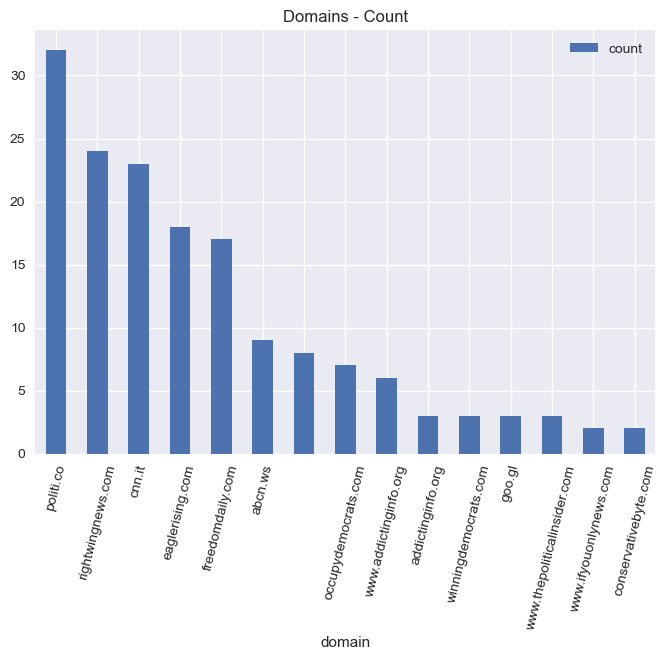

In [92]:
plt.style.use('seaborn')
t.head(15).plot(kind='bar')
plt.xticks(rotation=76)
plt.title('Domains - Count')
#Kind of looks like this dudes thing I just now realized ... 
#https://www.kaggle.com/code/sohamohajeri/buzzfeed-news-analysis-and-classification

In [99]:
df['domain'] = [urlparse(str(item)).netloc for item in df.source]
df_sum = pd.pivot_table(df,index='domain',columns='class',fill_value=0,aggfunc={'domain':'count'})
df_sum['%true'] = df_sum.apply(lambda row: round(row[1]/(row[0]+row[1]),4),axis=1)
df_sum[(df_sum['%true']!=1)&(df_sum['%true']!=0)].sort_values(by='%true')

# Doesn't completely work, see the dudes work above for possibly a better implementation
# this seems to just stop using some of the papers altogether, and it's not really a visual representation either so could be annoying to look at?

C:\Users\jakob\AppData\Local\Temp\ipykernel_12420\1831495377.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_sum['%true'] = df_sum.apply(lambda row: round(row[1]/(row[0]+row[1]),4),axis=1)


domain      %true
class                      0  1        
domain                                 
freedomdaily.com          16  1  0.0588
occupydemocrats.com        6  1  0.1429
rightwingnews.com         17  7  0.2917
winningdemocrats.com       2  1  0.3333
eaglerising.com           11  7  0.3889
conservativebyte.com       1  1  0.5000
www.addictinginfo.org      3  3  0.5000
addictinginfo.org          1  2  0.6667